In [1]:
import fastf1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

fastf1.__version__

'3.5.3'

In [2]:
fastf1.Cache.enable_cache('f1-cache')

In [ ]:
# get race session
session = fastf1.get_session(2024, 3, "R") 
session.load()

In [4]:
laps = session.laps[["Driver", "LapTime"]].copy()
laps.head()

,Driver,LapTime
0,VER,0 days 00:01:27.458000
1,VER,0 days 00:01:24.099000
2,VER,0 days 00:01:23.115000
3,VER,NaT
4,GAS,0 days 00:01:37.304000


In [ ]:
quali_ses = fastf1.get_session(2024, 3, "Q")
quali_ses.load()

In [6]:
quali_laps = quali_ses.laps.pick_quicklaps()
fastest_quali_laps = quali_laps.groupby("Driver")["LapTime"].min().reset_index()
fastest_quali_laps.rename(columns={"LapTime": "LapTime_Quali"}, inplace=True)

In [7]:
fastest_quali_laps.head()

,Driver,LapTime_Quali
0,ALB,0 days 00:01:17.130000
1,ALO,0 days 00:01:16.710000
2,BOT,0 days 00:01:17.340000
3,GAS,0 days 00:01:17.982000
4,HAM,0 days 00:01:16.960000


In [8]:
np.unique(laps["Driver"])

array(['ALB', 'ALO', 'BOT', 'GAS', 'HAM', 'HUL', 'LEC', 'MAG', 'NOR',
       'OCO', 'PER', 'PIA', 'RIC', 'RUS', 'SAI', 'STR', 'TSU', 'VER',
       'ZHO'], dtype=object)

In [9]:
np.unique(fastest_quali_laps["Driver"])

array(['ALB', 'ALO', 'BOT', 'GAS', 'HAM', 'HUL', 'LEC', 'MAG', 'NOR',
       'OCO', 'PER', 'PIA', 'RIC', 'RUS', 'SAI', 'STR', 'TSU', 'VER',
       'ZHO'], dtype=object)

In [10]:
laps.dropna(subset=["LapTime"], inplace=True)
laps["LapTime (s)"] = laps["LapTime"].dt.total_seconds()

In [11]:
fastest_quali_laps.dropna(subset=["LapTime_Quali"], inplace=True)
fastest_quali_laps["QualifyingTime (s)"] = fastest_quali_laps["LapTime_Quali"].dt.total_seconds()

In [12]:
laps.head()

,Driver,LapTime,LapTime (s)
0,VER,0 days 00:01:27.458000,87.458
1,VER,0 days 00:01:24.099000,84.099
2,VER,0 days 00:01:23.115000,83.115
4,GAS,0 days 00:01:37.304000,97.304
5,GAS,0 days 00:01:24.649000,84.649


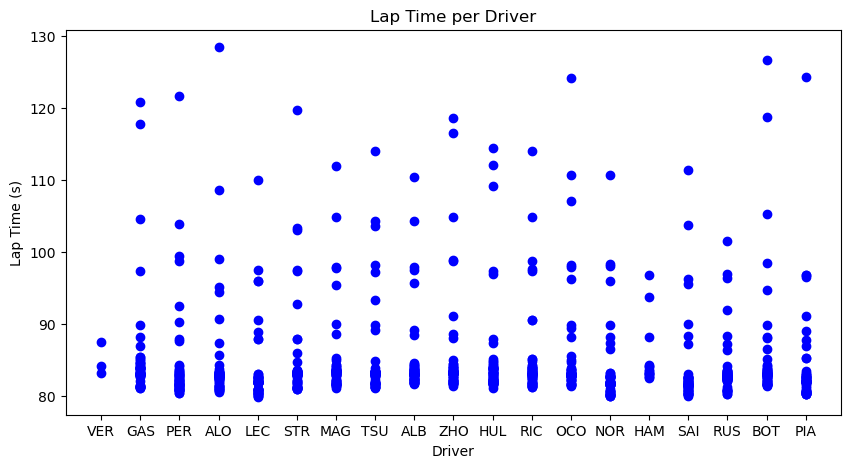

In [13]:
plt.figure(figsize=(10, 5))
plt.scatter(laps['Driver'], laps['LapTime (s)'], color='blue')
plt.xlabel('Driver')
plt.ylabel('Lap Time (s)')
plt.title('Lap Time per Driver')
plt.show()

In [14]:
fastest_quali_laps.head()

,Driver,LapTime_Quali,QualifyingTime (s)
0,ALB,0 days 00:01:17.130000,77.130
1,ALO,0 days 00:01:16.710000,76.710
2,BOT,0 days 00:01:17.340000,77.340
3,GAS,0 days 00:01:17.982000,77.982
4,HAM,0 days 00:01:16.960000,76.960


In [15]:
driver_mapping = {
    "Alexander Albon": "ALB",
    "Fernando Alonso": "ALO",
    "Valtteri Bottas": "BOT",
    "Pierre Gasly": "GAS",
    "Lewis Hamilton": "HAM",
    "Nico Hülkenberg": "HUL",
    "Charles Leclerc": "LEC",
    "Kevin Magnussen": "MAG",
    "Lando Norris": "NOR",
    "Esteban Ocon": "OCO",
    "Sergio Pérez": "PER",
    "Oscar Piastri": "PIA",
    "Daniel Ricciardo": "RIC",
    "George Russell": "RUS",
    "Carlos Sainz": "SAI",
    "Lance Stroll": "STR",
    "Yuki Tsunoda": "TSU",
    "Max Verstappen": "VER",
    "Zhou Guanyu": "ZHO"
}

In [16]:
mapping = {v: k for k, v in driver_mapping.items()}

# Building Qualifying DataFrame
qualifying = fastest_quali_laps[["Driver", "QualifyingTime (s)"]].copy()
qualifying["Driver"] = qualifying["Driver"].map(mapping)
qualifying["DriverCode"] = fastest_quali_laps["Driver"]
qualifying = qualifying[["Driver", "DriverCode", "QualifyingTime (s)"]]
display(qualifying)

,Driver,DriverCode,QualifyingTime (s)
0,Alexander Albon,ALB,77.130
1,Fernando Alonso,ALO,76.710
2,Valtteri Bottas,BOT,77.340
3,Pierre Gasly,GAS,77.982
4,Lewis Hamilton,HAM,76.960
5,Nico Hülkenberg,HUL,77.976
6,Charles Leclerc,LEC,76.304
7,Kevin Magnussen,MAG,77.427
8,Lando Norris,NOR,76.315
9,Esteban Ocon,OCO,77.617


In [17]:
data = qualifying.merge(laps, left_on="DriverCode", right_on="Driver")
data.drop(columns=["Driver_y", "LapTime"], inplace=True)
data.rename(columns={"Driver_x": "Driver"}, inplace=True)
display(data)

,Driver,DriverCode,QualifyingTime (s),LapTime (s)
0,Alexander Albon,ALB,77.130,95.752
1,Alexander Albon,ALB,77.130,84.536
2,Alexander Albon,ALB,77.130,83.606
3,Alexander Albon,ALB,77.130,83.438
4,Alexander Albon,ALB,77.130,83.916
...,...,...,...,...
990,Zhou Guanyu,ZHO,78.188,82.184
991,Zhou Guanyu,ZHO,78.188,82.067
992,Zhou Guanyu,ZHO,78.188,81.798
993,Zhou Guanyu,ZHO,78.188,88.058


In [18]:
X = data[["QualifyingTime (s)"]]
y = data["LapTime (s)"]
X.shape, y.shape

((995, 1), (995,))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((796, 1), (199, 1), (796,), (199,))

In [20]:
model_errors = {}  # Dictionary to store model name and MAE

In [21]:
# Actual vs Predicted Race Time
def quali_vs_race(df, model_name):
    plt.figure(figsize=(10, 6))
    sns.regplot(data=df, x="QualifyingTime (s)", y="PredictedRaceTime (s)", scatter_kws={'alpha':0.6})
    plt.title(f"Qualifying Time vs Race Time (using {model_name})")
    plt.xlabel("Qualifying Time (s)")
    plt.ylabel("Actual Race Time (s)")
    plt.tight_layout()
    plt.show()

In [22]:
# Helper Function
def predict_and_mae(model, model_name, original_df=data, X_test=X_test, y_test=y_test):
    df = data.copy()
    predicted = model.predict(df[["QualifyingTime (s)"]])
    df["PredictedRaceTime (s)"] = predicted

    df = df.drop_duplicates(subset=["Driver"]) # make sure the dataframe doesn't have any duplicates
    df = df.sort_values(by="PredictedRaceTime (s)") # to see you would be the winner

    print(f"Predicted 2025 Chinese GP Winner (using {model_name}):")
    print(df[["Driver", "PredictedRaceTime (s)"]])

    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"\nModel Error (MAE) using {model_name}: {mae:.5f} seconds")

    quali_vs_race(df, model_name)
    model_errors[model_name] = mae

In [23]:
# GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    random_state=42
)
model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=4, n_estimators=200, random_state=42)

Predicted 2025 Chinese GP Winner (using Gradient Boosting Regressor):
               Driver  PredictedRaceTime (s)
302   Charles Leclerc              82.479163
761      Carlos Sainz              83.140418
417      Lando Norris              83.320176
532      Sergio Pérez              83.328955
590     Oscar Piastri              83.598155
705    George Russell              83.623824
938       Zhou Guanyu              84.354429
648  Daniel Ricciardo              84.399358
229    Lewis Hamilton              84.662001
877      Yuki Tsunoda              84.942574
360   Kevin Magnussen              85.043620
0     Alexander Albon              85.058690
57    Fernando Alonso              85.303963
819      Lance Stroll              85.304069
475      Esteban Ocon              85.584045
172      Pierre Gasly              85.725057
244   Nico Hülkenberg              85.733055
115   Valtteri Bottas              85.889385
935    Max Verstappen              87.457918

Model Error (MAE) using Gradi

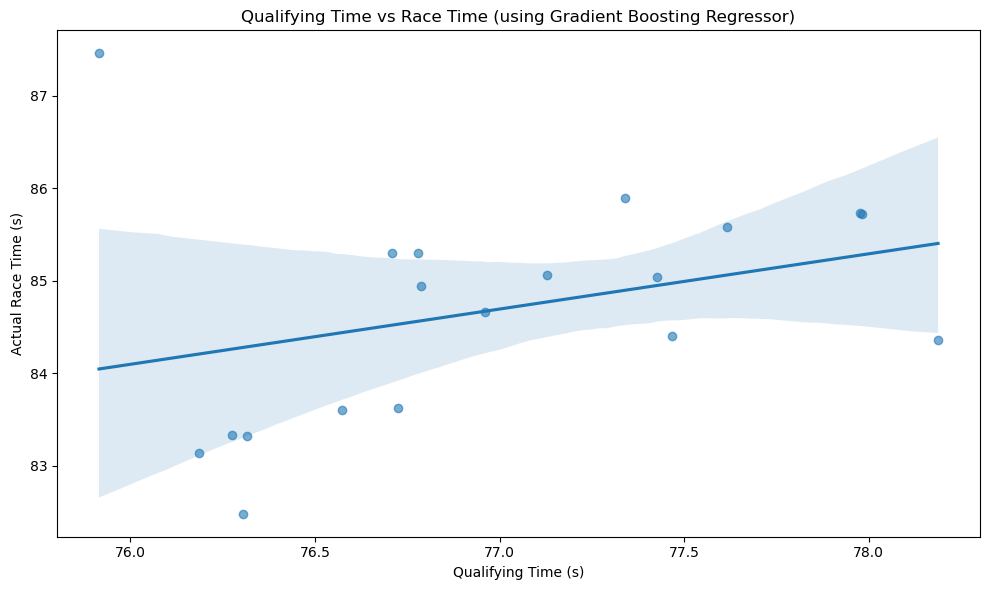

In [24]:
predict_and_mae(model, "Gradient Boosting Regressor")

In [25]:
# Linear Regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Predicted 2025 Chinese GP Winner (using Linear Regression):
               Driver  PredictedRaceTime (s)
935    Max Verstappen              83.237106
761      Carlos Sainz              83.545330
532      Sergio Pérez              83.646930
302   Charles Leclerc              83.681177
417      Lando Norris              83.693734
590     Oscar Piastri              83.987117
57    Fernando Alonso              84.144654
705    George Russell              84.160636
819      Lance Stroll              84.224564
877      Yuki Tsunoda              84.233696
229    Lewis Hamilton              84.430046
0     Alexander Albon              84.624113
115   Valtteri Bottas              84.863842
360   Kevin Magnussen              84.963159
648  Daniel Ricciardo              85.007680
475      Esteban Ocon              85.180057
244   Nico Hülkenberg              85.589880
172      Pierre Gasly              85.596730
938       Zhou Guanyu              85.831893

Model Error (MAE) using Linear Regressi

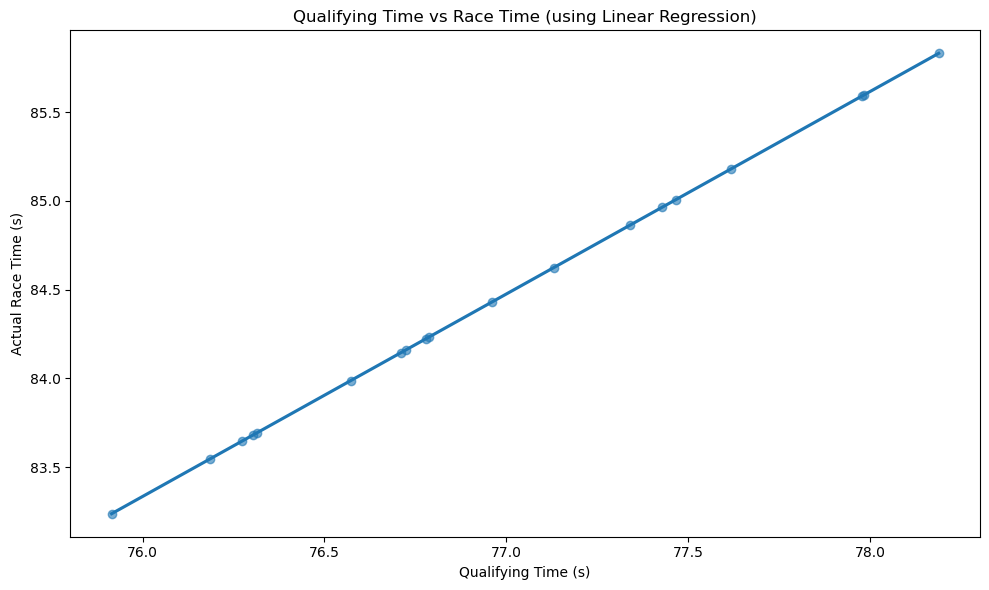

In [26]:
predict_and_mae(model, model_name="Linear Regression")

In [27]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(
    n_estimators=100, 
    random_state=42
)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Predicted 2025 Chinese GP Winner (using Random Forest Regressor):
               Driver  PredictedRaceTime (s)
302   Charles Leclerc              82.458474
761      Carlos Sainz              83.179524
532      Sergio Pérez              83.293249
417      Lando Norris              83.319921
590     Oscar Piastri              83.553535
705    George Russell              83.610087
938       Zhou Guanyu              84.346102
648  Daniel Ricciardo              84.444483
229    Lewis Hamilton              84.553228
877      Yuki Tsunoda              84.853889
360   Kevin Magnussen              84.980460
0     Alexander Albon              85.032677
57    Fernando Alonso              85.311789
819      Lance Stroll              85.340648
475      Esteban Ocon              85.545544
935    Max Verstappen              85.546953
115   Valtteri Bottas              85.678589
244   Nico Hülkenberg              85.688921
172      Pierre Gasly              85.724549

Model Error (MAE) using Random Fo

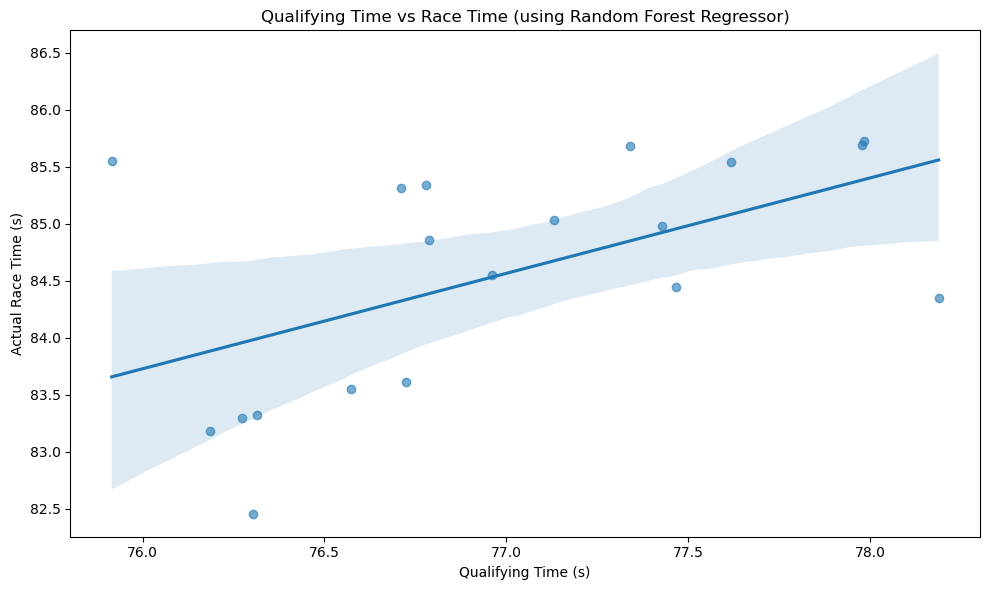

In [28]:
predict_and_mae(model, model_name="Random Forest Regressor")

In [29]:
# XGB Regressor
from xgboost import XGBRegressor
model = XGBRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=3, 
    subsample=0.8, colsample_bytree=0.8, random_state=42
)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

Predicted 2025 Chinese GP Winner (using XGBoost Regressor):
               Driver  PredictedRaceTime (s)
302   Charles Leclerc              82.606331
761      Carlos Sainz              83.144798
532      Sergio Pérez              83.380417
417      Lando Norris              83.437057
590     Oscar Piastri              83.575790
705    George Russell              83.657715
938       Zhou Guanyu              84.360443
648  Daniel Ricciardo              84.451271
229    Lewis Hamilton              84.721146
877      Yuki Tsunoda              84.918892
0     Alexander Albon              84.999657
819      Lance Stroll              85.099213
360   Kevin Magnussen              85.153435
57    Fernando Alonso              85.291115
475      Esteban Ocon              85.492027
172      Pierre Gasly              85.584991
244   Nico Hülkenberg              85.615593
115   Valtteri Bottas              85.766808
935    Max Verstappen              86.851456

Model Error (MAE) using XGBoost Regress

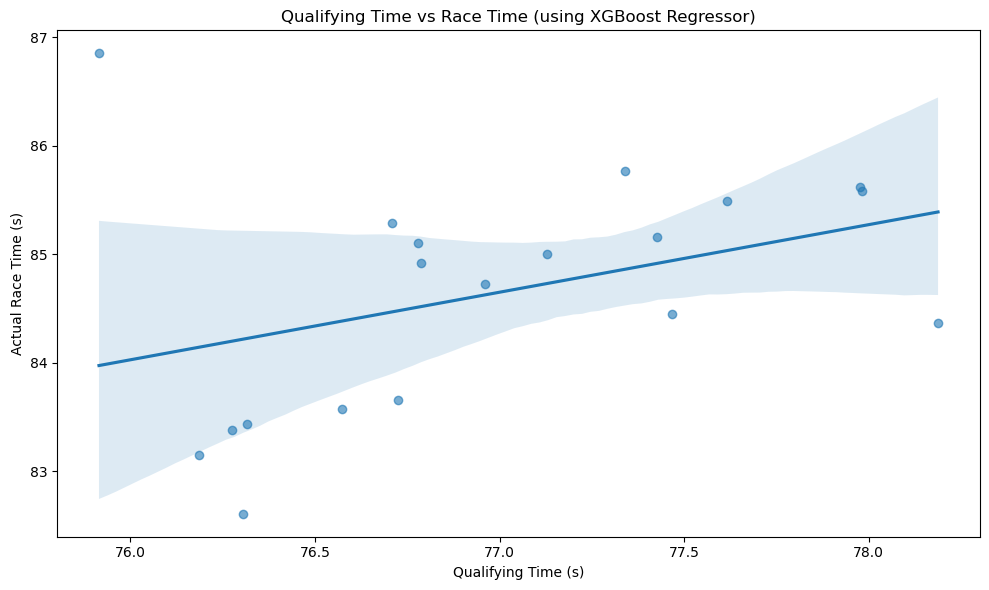

In [30]:
predict_and_mae(model, model_name="XGBoost Regressor")

In [31]:
# Stacking Regressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

model = StackingRegressor(
    estimators=[
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('xgb', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)),
        ('gb', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
    ],
    final_estimator=RidgeCV(),
    passthrough=True
)
model.fit(X_train, y_train)

StackingRegressor(estimators=[('rf', RandomForestRegressor(random_state=42)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy...
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                              ('gb',
                               GradientBoostingRegressor(random_state=42))],
                  final_estimator=RidgeCV(), passthrough=True)

Predicted 2025 Chinese GP Winner (using Stacking Regressor (rf, xgb, gb, ridgecv)):
               Driver  PredictedRaceTime (s)
57    Fernando Alonso              83.394105
819      Lance Stroll              83.399108
761      Carlos Sainz              83.641109
417      Lando Norris              83.880235
532      Sergio Pérez              83.881054
877      Yuki Tsunoda              84.103498
590     Oscar Piastri              84.320773
0     Alexander Albon              84.425356
302   Charles Leclerc              84.467984
705    George Russell              84.547660
115   Valtteri Bottas              84.918886
229    Lewis Hamilton              84.980122
475      Esteban Ocon              85.023332
360   Kevin Magnussen              85.086668
648  Daniel Ricciardo              85.200498
172      Pierre Gasly              85.429143
244   Nico Hülkenberg              85.552470
938       Zhou Guanyu              86.603396
935    Max Verstappen              87.590912

Model Error (MA

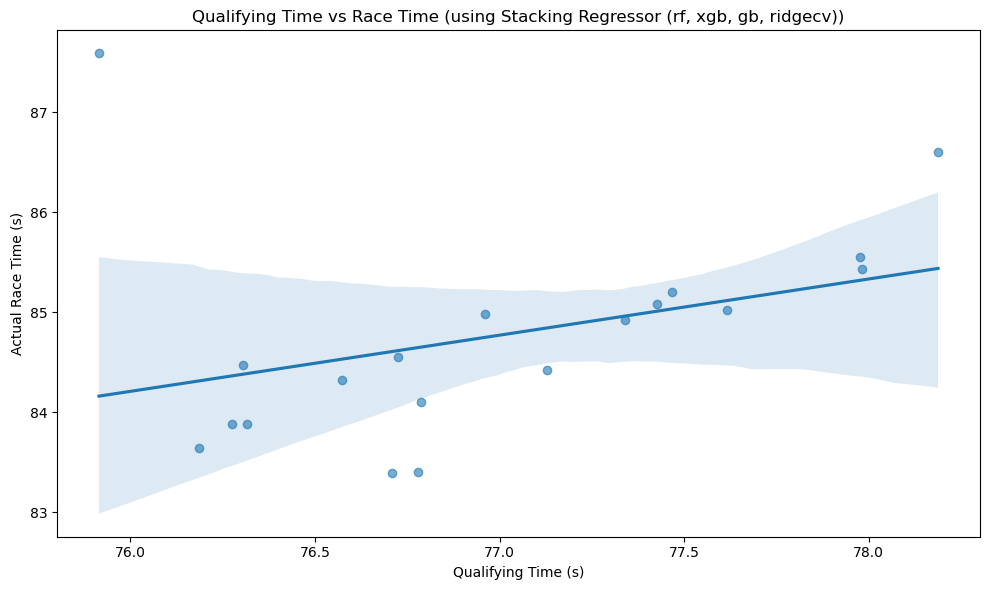

In [32]:
predict_and_mae(model, "Stacking Regressor (rf, xgb, gb, ridgecv)")

In [33]:
result = pd.DataFrame(list(model_errors.items()), columns=['Model', 'MAE (s)'])
result = result.sort_values(by='MAE (s)').reset_index(drop=True)

In [34]:
print("--- Model MAE Comparison ---")
print(result)

--- Model MAE Comparison ---
                                       Model   MAE (s)
0                          Linear Regression  3.798852
1  Stacking Regressor (rf, xgb, gb, ridgecv)  3.813657
2                    Random Forest Regressor  3.917842
3                          XGBoost Regressor  3.928077
4                Gradient Boosting Regressor  3.957048


In [35]:
best_model = result.iloc[0]
print(f"\n🏁 Best Model: {best_model['Model']} with MAE = {best_model['MAE (s)']:.5f} seconds")


🏁 Best Model: Linear Regression with MAE = 3.79885 seconds


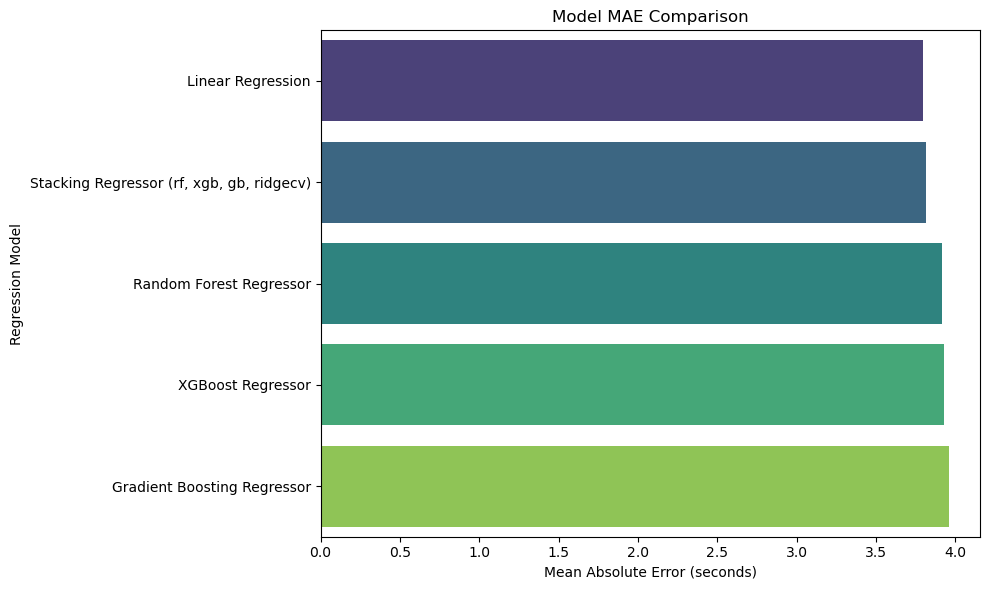

In [36]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=result,
    x="MAE (s)",
    y="Model",
    hue="Model",            
    dodge=False,            
    palette="viridis",
    legend=False            
)
plt.title("Model MAE Comparison")
plt.xlabel("Mean Absolute Error (seconds)")
plt.ylabel("Regression Model")
plt.tight_layout()
plt.show()